In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import seaborn as sns
import pickle
from imblearn.over_sampling import ADASYN
import tensorflow as tf

In [2]:
df = pd.read_csv('pre_encoding_data.csv')

In [3]:
df.columns

Index(['proj_code', 'country', 'via', 'inco', 'ship_mode', 'prod_grp',
       'sub_class', 'vendor', 'brand', 'dosage', 'dosage_form', 'per_pack_qty',
       'line_qty', 'line_value', 'pack_price', 'unit_price', 'manu_site',
       'first_line', 'weight', 'freight', 'insurance', 'delay', 'total_cost',
       'quote_year', 'quote_month', 'quote_day', 'po_year', 'po_month',
       'po_day', 'sch_del_year', 'sch_del_month', 'sch_del_day',
       'actual_del_year', 'actual_del_month', 'actual_del_day'],
      dtype='object')

In [4]:
# Drop unnecessary columns to prevent overfitting
df = df.drop(['prod_grp','sub_class','brand', 'dosage', 'dosage_form', 'per_pack_qty','line_qty','pack_price', 'unit_price',
              'first_line', 'delay','actual_del_year', 'actual_del_month', 'actual_del_day','freight','total_cost'], axis=1)

In [5]:
df.columns

Index(['proj_code', 'country', 'via', 'inco', 'ship_mode', 'vendor',
       'line_value', 'manu_site', 'weight', 'insurance', 'quote_year',
       'quote_month', 'quote_day', 'po_year', 'po_month', 'po_day',
       'sch_del_year', 'sch_del_month', 'sch_del_day'],
      dtype='object')

In [6]:
cat_feats = df.dtypes[df.dtypes == 'object'].index.tolist()
num_feats = df.dtypes[~df.dtypes.index.isin(cat_feats)].index.tolist()

#Convert cat_feats to categorical
for col in cat_feats:
    df[col] = df[col].astype('str')

# Removing Shipment Mode from cat_feats as it is the dependant variable
cat_feats.remove('ship_mode')

In [7]:
X = df.drop(columns=['ship_mode'])
l = LabelEncoder()
y = l.fit_transform(df['ship_mode'])

In [8]:
LABEL_MAP = dict(zip(l.classes_, l.transform(l.classes_)))

In [9]:
# Create Pipeline
numerical = Pipeline([('standard_scaler', StandardScaler())])
                            
categorical = Pipeline([('encode', OneHotEncoder()),('Dense',FunctionTransformer(csr_matrix.todense))])

preprocess = ColumnTransformer([('categorical', categorical, cat_feats),('numerical', numerical, num_feats)])

In [10]:
#Fit Preprocess to data
X = preprocess.fit_transform(X)
# Use Adaptive Synthetic Sampling Approach to remove imbalance in data
ada = ADASYN()
X, y = ada.fit_resample(X, y)

In [11]:
X.shape

(24633, 367)

In [12]:
# save the preprocess
pickle.dump(preprocess, open('preprocess2.pkl', 'wb'))

In [13]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=50)
X_train.shape

(18474, 367)

In [35]:
inputs = tf.keras.Input(shape=X_train.shape[1])
hide1 = tf.keras.layers.Dense(256, activation='relu')(inputs)
hide2 = tf.keras.layers.Dense(128, activation='relu')(hide1)
hide3 = tf.keras.layers.Dense(64, activation='relu')(hide2)
hide4 = tf.keras.layers.Dense(32, activation='relu')(hide3)
outputs = tf.keras.layers.Dense(4, activation='softmax')(hide4)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(X_train,y_train,validation_split=0.2,batch_size=32,epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/100
462/462 [==============================] - 2s 4ms/step - loss: 0.2718 - accuracy: 0.9078 - val_loss: 0.1512 - val_accuracy: 0.9497
Epoch 2/100
462/462 [==============================] - 2s 4ms/step - loss: 0.1243 - accuracy: 0.9595 - val_loss: 0.1140 - val_accuracy: 0.9618
Epoch 3/100
462/462 [==============================] - 2s 4ms/step - loss: 0.0984 - accuracy: 0.9670 - val_loss: 0.1012 - val_accuracy: 0.9673
Epoch 4/100
462/462 [==============================] - 2s 4ms/step - loss: 0.0870 - accuracy: 0.9719 - val_loss: 0.1049 - val_accuracy: 0.9675
Epoch 5/100
462/462 [==============================] - 2s 4ms/step - loss: 0.0746 - accuracy: 0.9743 - val_loss: 0.1117 - val_accuracy: 0.9710
Epoch 6/100
462/462 [==============================] - 2s 5ms/step - loss: 0.0681 - accuracy: 0.9769 - val_loss: 0.0969 - val_accuracy: 0.9732
Epoch 7/100
462/462 [==============================] - 2s 5ms/step - loss: 0.0678 - accuracy: 0.9786 - val_loss: 0.1001 - val_accuracy: 0.9713

Test Set Accuracy: 97.30%


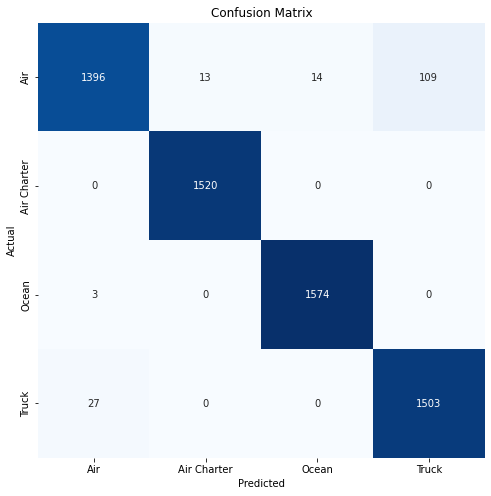

Classification Report:
----------------------
               precision    recall  f1-score   support

         Air       0.98      0.91      0.94      1532
 Air Charter       0.99      1.00      1.00      1520
       Ocean       0.99      1.00      0.99      1577
       Truck       0.93      0.98      0.96      1530

    accuracy                           0.97      6159
   macro avg       0.97      0.97      0.97      6159
weighted avg       0.97      0.97      0.97      6159



In [27]:
# Transform preprocess and save for deployment
y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred, labels=list(LABEL_MAP.values()))
clr = classification_report(y_test, y_pred, labels=list(LABEL_MAP.values()), target_names=list(LABEL_MAP.keys()))

print("Test Set Accuracy: {:.2f}%".format(model.evaluate(X_test, y_test, verbose=0)[1] * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=list(LABEL_MAP.keys()))
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=list(LABEL_MAP.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [37]:
# Save the model
model.save('best_mode_transport2')

INFO:tensorflow:Assets written to: best_mode_transport2/assets


In [19]:
#from ann_visualizer.visualize import ann_viz

In [ ]:
#ann_viz(model, view=True, filename='mode_network.gv', title='Neuarl Network To Predict Best Mode')